# Compare the GM-SEUS products (arrays & individual panels) to the existing collected dataproducts (USPVDB, CCPV, SAM, OSM, and OSM/CCPV panel shapes )  

For GMSEUS "Big Panel" paper with Jacob Stid (stidjaco@msu.edu)  
Work in this notebook from Jeremy Rapp (rappjer1@gmail.com) 

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

### Polygon comparison

   arrayID nativeID Source        area  instYr PnlSource  panelID  numPanels  \
0        0        0  CCVPV  106.764365  2018.0  existing   719587         25   
1        1     1568  CCVPV  221.753275  2018.0  existing   720805          4   
2        2   180011  CCVPV   85.285502  2015.0  existing   893196       1704   
3        3    10000    OSM   92.299999     NaN    gmseus  2511288          8   
4        4    10001    OSM   61.764114     NaN    gmseus  2496849          8   

         pnlArea                                           geometry  
0    5722.924336  POLYGON ((-2046953.18 -33173.397, -2046953.138...  
1     986.133346  POLYGON ((-2059299.539 33325.627, -2059299.524...  
2  155990.402240  MULTIPOLYGON (((-2181290.313 245796.767, -2181...  
3    1435.099913  POLYGON ((1795489.97 961952.324, 1795490.142 9...  
4     569.159987  POLYGON ((1806395.395 972398.064, 1806395.521 ...  
(8203, 10)
GMSEUS arrays attributes
count    8.203000e+03
mean     1.135112e+05
std      4.761901e+

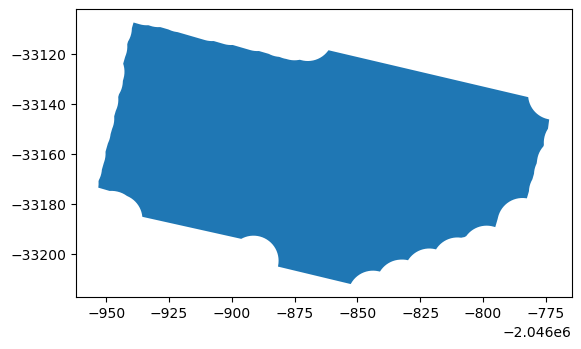

In [43]:
# load the panel polygons for comparison
gmseus_arrays = gpd.read_file('G:\\Data\\GMSEUS\\GMSEUS\\GMSEUS_NAIP_Arrays.shp')

# print the first few rows of the data
print(gmseus_arrays.head())
print(gmseus_arrays.shape)
print('GMSEUS arrays attributes')
print(gmseus_arrays.area.describe())


# create a subset of the data 10 rows long
gmseus_arrays_subset = gmseus_arrays.head(1)

# plot the subset of the data
gmseus_arrays_subset.plot()
plt.show()


In [12]:

def explode_geometries(gdf):
    """
    Explode a GeoDataFrame so that each row contains only one polygon/multipolygon part.
    """
    exploded_gdf = gdf.explode(index_parts=True).reset_index(drop=True)
    return exploded_gdf



def calculate_pairwise_jaccard(shapefile_a, shapefile_b):
    # Load datasets
    gdf_a = gpd.read_file(shapefile_a)
    gdf_b = gpd.read_file(shapefile_b)
    
    # Explode geometries
    gdf_a_exploded = gdf_a.explode(index_parts=True).reset_index(drop=True)
    gdf_b_exploded = gdf_b.explode(index_parts=True).reset_index(drop=True)
    
    # Ensure CRS match
    if gdf_a_exploded.crs != gdf_b_exploded.crs:
        gdf_b_exploded = gdf_b_exploded.to_crs(gdf_a_exploded.crs)
    
    # Perform spatial join to find intersecting rows
    intersecting_pairs = gpd.sjoin(gdf_a_exploded, gdf_b_exploded, how="inner", predicate="intersects")
    
    # Add IDs to original datasets for tracking
    gdf_a_exploded['id_a'] = gdf_a_exploded.index
    gdf_b_exploded['id_b'] = gdf_b_exploded.index
    
    # Merge the intersecting pairs to get geometry pairs
    intersecting_pairs = intersecting_pairs.merge(
        gdf_b_exploded[['geometry', 'id_b']],
        left_on='index_right', right_index=True, suffixes=('_a', '_b')
    )
    
    # Calculate Jaccard index for each intersecting pair
    jaccard_results = []
    for _, row in intersecting_pairs.iterrows():
        geom_a = row['geometry_a']
        geom_b = row['geometry_b']
        
        # Calculate intersection and union
        intersection_area = geom_a.intersection(geom_b).area
        union_area = geom_a.union(geom_b).area
        
        # Calculate Jaccard index
        jaccard_index = intersection_area / union_area if union_area != 0 else 0
        
        # Store results
        jaccard_results.append({
            'id_a': row['id_a'],
            'id_b': row['id_b'],
            'jaccard_index': jaccard_index
        })
    
    # Convert results to DataFrame
    jaccard_df = pd.DataFrame(jaccard_results)
    
    return jaccard_df

In [8]:
# Explode the geometries
exploded_gmseus = explode_geometries(gmseus_arrays)

# Print the first few rows of the exploded data
print(exploded_gmseus.head())

   arrayID nativeID Source        area  instYr PnlSource  panelID  numPanels  \
0        0        0  CCVPV  106.764365  2018.0  existing   719587         25   
1        1     1568  CCVPV  221.753275  2018.0  existing   720805          4   
2        2   180011  CCVPV   85.285502  2015.0  existing   893196       1704   
3        2   180011  CCVPV   85.285502  2015.0  existing   893196       1704   
4        3    10000    OSM   92.299999     NaN    gmseus  2511288          8   

         pnlArea                                           geometry  
0    5722.924336  POLYGON ((-2046953.18 -33173.397, -2046953.138...  
1     986.133346  POLYGON ((-2059299.539 33325.627, -2059299.524...  
2  155990.402240  POLYGON ((-2181290.313 245796.767, -2181279.16...  
3  155990.402240  POLYGON ((-2180965.63 246104.307, -2180959.91 ...  
4    1435.099913  POLYGON ((1795489.97 961952.324, 1795490.142 9...  


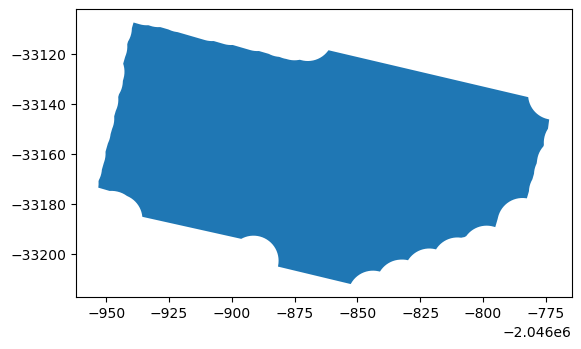

In [9]:
# Get the first few rows of the exploded data
exploded_gmseus_subset = exploded_gmseus.head(1)

# Plot the exploded data
exploded_gmseus_subset.plot()
plt.show()


  nativeID  instYr  cap_mw       area    modType AVtype  azimuth        mount  \
0   401476    2016   100.2  1735134.0       c-si   None    180.0  single_axis   
1   401865    2017    12.7   187820.0  thin-film   None    180.0  single_axis   
2   401866    2017     9.7    39717.0  thin-film   None    180.0         None   
3   402674    2017    12.5   194595.0       c-si   None    180.0  single_axis   
4   401807    2017   116.9  1881927.0       c-si   None    180.0  single_axis   

   Source                                           geometry  
0  USPVDB  MULTIPOLYGON Z (((738788.612 -265689.712 0, 73...  
1  USPVDB  MULTIPOLYGON Z (((971961.129 -636561.614 0, 97...  
2  USPVDB  MULTIPOLYGON Z (((925171.423 -384591.972 0, 92...  
3  USPVDB  MULTIPOLYGON Z (((853104.416 -280973.172 0, 85...  
4  USPVDB  MULTIPOLYGON Z (((985679.478 -461141.159 0, 98...  
(4185, 10)
USPVDB arrays attributes
count    4.185000e+03
mean     3.836397e+05
std      1.004317e+06
min      1.560708e+03
25%      3.

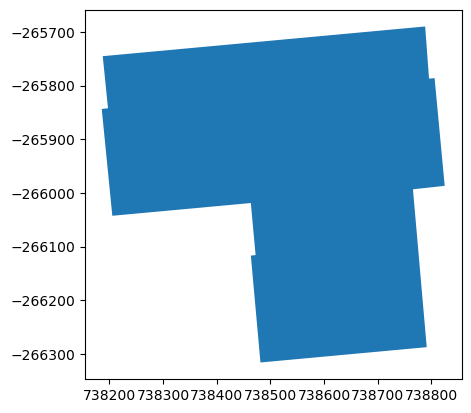

In [45]:
uspvdb_arrays = gpd.read_file('G:\\Data\\GMSEUS\\intermediateProducts\\uspvdb_poly.shp')
#print(uspvdb_arrays.head())


# print the first few rows of the data
print(uspvdb_arrays.head())
print(uspvdb_arrays.shape)
print('USPVDB arrays attributes')
print(uspvdb_arrays.area.describe())


# Explode the geometries
exploded_uspvdb = explode_geometries(uspvdb_arrays)

# Print the first few rows of the exploded data
print(exploded_uspvdb.head())

# Get the first few rows of the exploded data
exploded_uspvdb_subset = exploded_uspvdb.head(1)

# Plot the exploded data
exploded_uspvdb_subset.plot()
plt.show()

In [46]:
# Check CRS
print(exploded_gmseus.crs)
print(exploded_uspvdb.crs)


PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",37.5],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102003"]]
PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","42

In [47]:
# Print information about the exploded data
print(gmseus_arrays.shape)
print(uspvdb_arrays.shape)
print(exploded_gmseus.shape)
print(exploded_uspvdb.shape)

# Average size of exploded geometries
print(exploded_gmseus.shape)
print('GMSEUS exploded arrays attributes')
print(exploded_gmseus.area.describe())
print(' ')
print(exploded_uspvdb.shape)
print('USPVDB exploded arrays attributes')
print(exploded_uspvdb.area.describe())

(8203, 10)
(4185, 10)
(16008, 10)
(9890, 10)
(16008, 10)
GMSEUS exploded arrays attributes
count    1.600800e+04
mean     5.816669e+04
std      2.004533e+05
min      1.500648e+01
25%      1.414529e+03
50%      9.049109e+03
75%      3.378401e+04
max      5.908512e+06
dtype: float64
 
(9890, 10)
USPVDB exploded arrays attributes
count    9.890000e+03
mean     1.623390e+05
std      3.600724e+05
min      3.125993e-04
25%      2.214525e+04
50%      5.019874e+04
75%      1.322024e+05
max      7.684568e+06
dtype: float64


In [21]:
def calculate_pairwise_jaccard_with_areas(shapefile_a, shapefile_b):
    # Load datasets
    gdf_a = gpd.read_file(shapefile_a)
    gdf_b = gpd.read_file(shapefile_b)
    
    # Explode geometries
    gdf_a_exploded = gdf_a.explode(index_parts=True).reset_index()
    gdf_b_exploded = gdf_b.explode(index_parts=True).reset_index()
    
    # Ensure GeoDataFrame and geometry column are valid
    if 'geometry' not in gdf_a_exploded.columns:
        gdf_a_exploded = gdf_a_exploded.set_geometry('geometry')
    if 'geometry' not in gdf_b_exploded.columns:
        gdf_b_exploded = gdf_b_exploded.set_geometry('geometry')
    
    # Add IDs and calculate areas for tracking
    gdf_a_exploded['id_a'] = gdf_a_exploded.index
    gdf_a_exploded['area_a'] = gdf_a_exploded.geometry.area  # Calculate areas
    gdf_b_exploded['id_b'] = gdf_b_exploded.index
    gdf_b_exploded['area_b'] = gdf_b_exploded.geometry.area  # Calculate areas

    # Ensure CRS match
    if gdf_a_exploded.crs != gdf_b_exploded.crs:
        gdf_b_exploded = gdf_b_exploded.to_crs(gdf_a_exploded.crs)
    
    # Perform spatial join to find intersecting rows
    intersecting_pairs = gpd.sjoin(
        gdf_a_exploded[['id_a', 'geometry', 'area_a']],
        gdf_b_exploded[['id_b', 'geometry', 'area_b']],
        how="inner",
        predicate="intersects"
    )
    
    # Merge geometries for Jaccard calculation
    intersecting_pairs = intersecting_pairs.merge(
        gdf_b_exploded[['id_b', 'geometry', 'area_b']],
        on='id_b',
        suffixes=('_a', '_b')
    )
    
    # Rename columns for clarity and prevent suffix issues
    intersecting_pairs.rename(columns={
        'geometry': 'geometry_a',
        'geometry_b': 'geometry_b',
        'area_b_b': 'area_b'  # Ensuring `area_b` is correctly named
    }, inplace=True)
    
    # Debugging: Check final columns
    print("Final Intersecting Pairs Columns:", intersecting_pairs.columns)
    
    # Calculate Jaccard index for each intersecting pair
    jaccard_results = []
    for _, row in intersecting_pairs.iterrows():
        geom_a = row['geometry_a']
        geom_b = row['geometry_b']
        
        # Calculate intersection and union
        intersection_area = geom_a.intersection(geom_b).area
        union_area = geom_a.union(geom_b).area
        
        # Calculate Jaccard index
        jaccard_index = intersection_area / union_area if union_area != 0 else 0
        
        # Store results, including areas
        jaccard_results.append({
            'id_a': row['id_a'],
            'id_b': row['id_b'],
            'area_a': row['area_a'],
            'area_b': row['area_b'],
            'intersection_area': intersection_area,
            'union_area': union_area,
            'jaccard_index': jaccard_index
        })
    
    # Convert results to DataFrame
    jaccard_df = pd.DataFrame(jaccard_results)
    
    return jaccard_df

# Example usage
shapefile_a = "G:\\Data\\GMSEUS\\GMSEUS\\GMSEUS_NAIP_Arrays.shp"
shapefile_b = "G:\\Data\\GMSEUS\\intermediateProducts\\uspvdb_poly.shp"

jaccard_df = calculate_pairwise_jaccard_with_areas(shapefile_a, shapefile_b)

Final Intersecting Pairs Columns: Index(['id_a', 'geometry_a', 'area_a', 'index_right', 'id_b', 'area_b_a',
       'geometry_b', 'area_b'],
      dtype='object')


   id_a  id_b         area_a         area_b  intersection_area     union_area  \
0  2997  3023   18528.722022   21128.744550       18527.479862   21129.986710   
1  2998  3272  142112.295892  150349.201452      142077.703485  150383.793860   
2  2999  4982   29551.856232   32775.592566       29549.983793   32777.465005   
3  3000  7611   26940.239624   31605.580987       26939.900189   31605.920423   
4  3001  7699   44836.928886   50723.356421       44836.928886   50723.356421   

   jaccard_index  log_area_a  log_area_b  
0       0.876833    4.267845    4.324874  
1       0.944767    5.152632    5.177101  
2       0.901534    4.470585    4.515551  
3       0.852369    4.430401    4.499764  
4       0.883950    4.651636    4.705208  
(9593, 9)


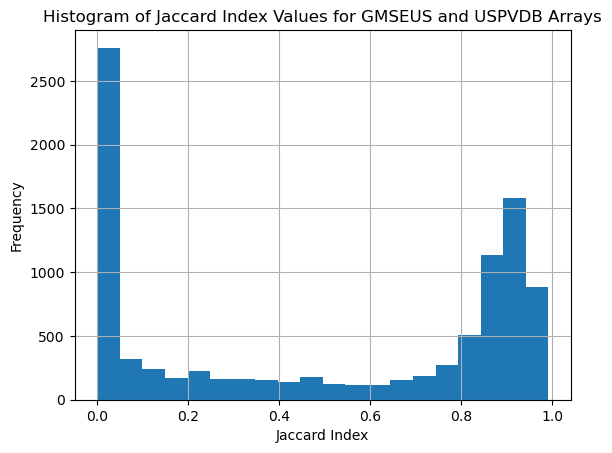

In [40]:
print(jaccard_df.head())
print(jaccard_df.shape)
# plot a histogram of the Jaccard index values
jaccard_df['jaccard_index'].hist(bins=20)
plt.xlabel('Jaccard Index')
plt.ylabel('Frequency')
plt.title('Histogram of Jaccard Index Values for GMSEUS and USPVDB Arrays')
plt.show()

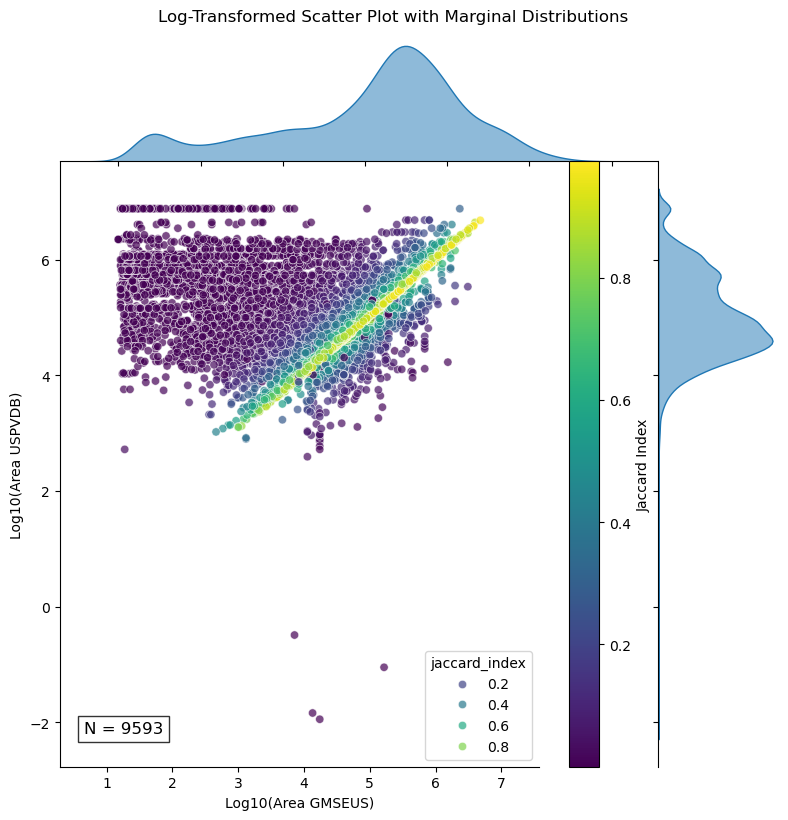

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



In [27]:
def count_intersections_and_list_polygons(jaccard_df):
    # Group by id_a to analyze intersections for each polygon in dataset A
    grouped_by_a = jaccard_df.groupby('id_a').agg(
        num_intersections=('id_b', 'count'),  # Count the number of intersections
        unique_polygons=('id_b', lambda x: list(x.unique()))  # List unique IDs of polygons
    ).reset_index()

    # Group by id_b to analyze intersections for each polygon in dataset B
    grouped_by_b = jaccard_df.groupby('id_b').agg(
        num_intersections=('id_a', 'count'),
        unique_polygons=('id_a', lambda x: list(x.unique()))
    ).reset_index()

    return grouped_by_a, grouped_by_b

# Example usage
grouped_by_a, grouped_by_b = count_intersections_and_list_polygons(jaccard_df)


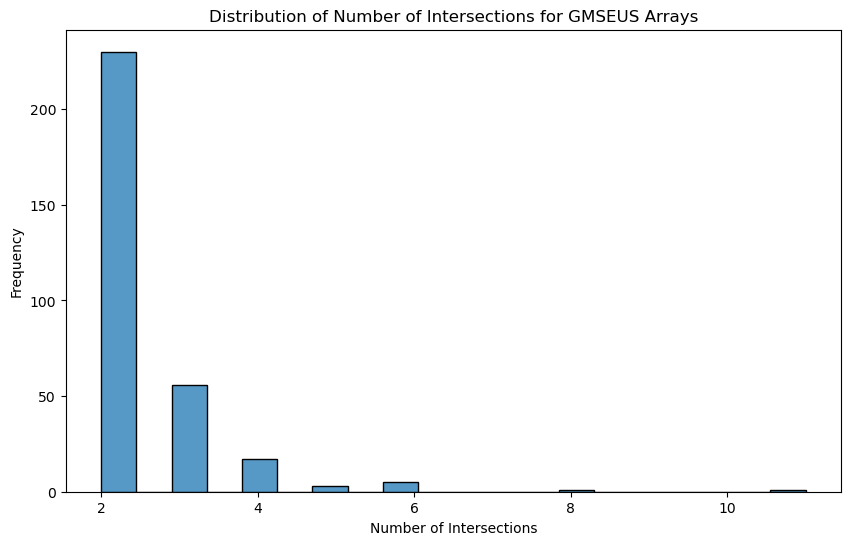

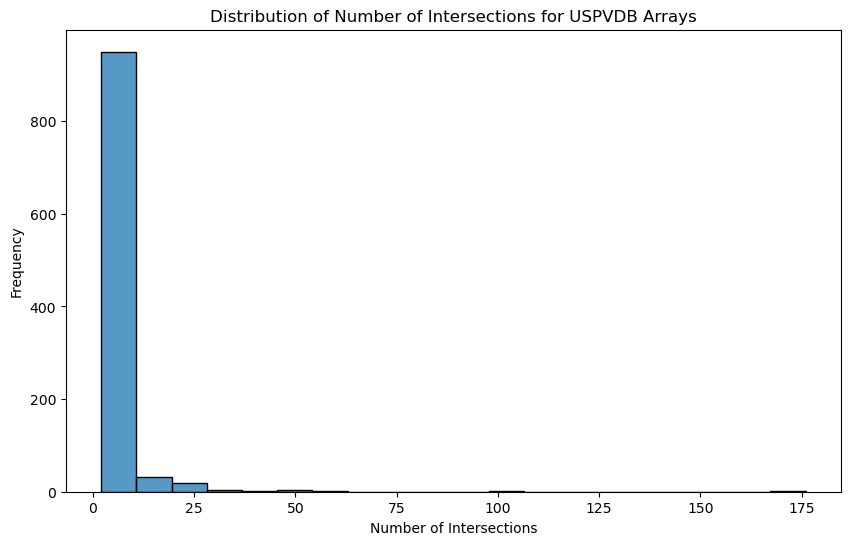

In [32]:
# only keep the polygons that have more than 1 intersection
grouped_by_a_filtered = grouped_by_a[grouped_by_a['num_intersections'] > 1]
grouped_by_b_filtered = grouped_by_b[grouped_by_b['num_intersections'] > 1]

# Plot the distribution of the number of intersections for each polygon in dataset A
plt.figure(figsize=(10, 6))
sns.histplot(grouped_by_a_filtered['num_intersections'], bins=20, kde=False)
plt.xlabel('Number of Intersections')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Intersections for GMSEUS Arrays')
plt.show()

# Plot the distribution of the number of intersections for each polygon in dataset B
plt.figure(figsize=(10, 6))
sns.histplot(grouped_by_b_filtered['num_intersections'], bins=20, kde=False)
plt.xlabel('Number of Intersections')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Intersections for USPVDB Arrays')
plt.show()

In [68]:
def calculate_gof_and_jaccard_vectorized(map1, map2):
    """
    Calculate Goodness-of-Fit (GOF) and Jaccard Index for intersections between two maps using vectorized operations.
    
    Parameters:
        map1 (GeoDataFrame): First map with polygons to be compared.
        map2 (GeoDataFrame): Second map with polygons serving as the reference.
        
    Returns:
        intersections_gdf (GeoDataFrame): GeoDataFrame with intersections, Jaccard, and GOF scores.
        overall_gof (float): Overall GOF score for map1.
        average_jaccard (float): Average Jaccard Index for all intersections.
    """
    # Explode geometries for both maps
    map1 = map1.explode(index_parts=True).reset_index(drop=True)
    map2 = map2.explode(index_parts=True).reset_index(drop=True)

    # Ensure CRS match
    if map1.crs != map2.crs:
        map2 = map2.to_crs(map1.crs)
    
    # Add an explicit ID column to keep track of original indices
    map1['id_a'] = map1.index
    map2['id_b'] = map2.index

    # Perform spatial intersection to get intersected geometries
    intersections = gpd.overlay(map1, map2, how="intersection")

    # Add areas for map1, map2, and intersections
    map1['area_a'] = map1.geometry.area
    map2['area_b'] = map2.geometry.area
    intersections['intersection_area'] = intersections.geometry.area

    # Merge area attributes using explicit IDs
    intersections = intersections.merge(
        map1[['id_a', 'area_a']],
        on='id_a',
        how='left'
    )
    intersections = intersections.merge(
        map2[['id_b', 'area_b']],
        on='id_b',
        how='left'
    )

    # Calculate Jaccard Index
    intersections['union_area'] = intersections['area_a'] + intersections['area_b'] - intersections['intersection_area']
    intersections['jaccard_index'] = intersections['intersection_area'] / intersections['union_area']

    # Calculate GOF
    intersections['insideness'] = intersections['intersection_area'] / intersections['area_b']
    intersections['weight'] = intersections['intersection_area'] / intersections['area_a']
    intersections['gof'] = intersections['insideness'] * intersections['weight']
    
    # Calculate overall metrics
    overall_gof = intersections.groupby('id_a')['gof'].sum().mean()
    average_jaccard = intersections['jaccard_index'].mean()

    return intersections, overall_gof, average_jaccard


# Example usage
map1 = gmseus_arrays
print(map1.is_valid.all())

map2 = uspvdb_arrays
map2['geometry'] = map2.buffer(0)
print(map2.is_valid.all())  # Should now return True

# Calculate GOF and Jaccard
intersections_gdf, overall_gof, average_jaccard = calculate_gof_and_jaccard_vectorized(map1, map2)


True
True


In [69]:
print(intersections_gdf.head())

   arrayID    nativeID_1 Source_1      area_1  instYr_1 PnlSource  panelID  \
0     3148  1223378715_0      OSM  532.385500   -9999.0  existing   219110   
1     3149  1231856776_0      OSM  657.345289    2016.0  existing   244527   
2     3150  1223081998_0      OSM  127.020477    2018.0  existing   300907   
3     3151  1022536639_0      OSM  486.395237    2010.0  existing   617726   
4     3152        400011   USPVDB  140.409256       NaN    gmseus  2303979   

   numPanels       pnlArea             x  ...  id_b  \
0         19   8578.641209  4.844886e+05  ...  3023   
1        199  97213.068456  9.818911e+05  ...  3272   
2         77   9789.361028 -3.798181e+04  ...  4982   
3         32  12332.403599  1.001035e+06  ...  7611   
4        136  25032.337408 -1.507987e+05  ...  7699   

                                            geometry intersection_area  \
0  POLYGON Z ((484384.077 455076.518 0, 484401.79...      18527.479862   
1  POLYGON Z ((981669.084 89486.913 0, 981696.968...

In [54]:
print(map1.crs)
print(map2.crs)

print(map1.is_valid.all())
print(map2.is_valid.all())

print(map1.total_bounds)  # [minx, miny, maxx, maxy]
print(map2.total_bounds)

PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",37.5],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102003"]]
PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","42

Overall GOF: 0.5235303986732286
Average Jaccard Index: 0.5009830859244853


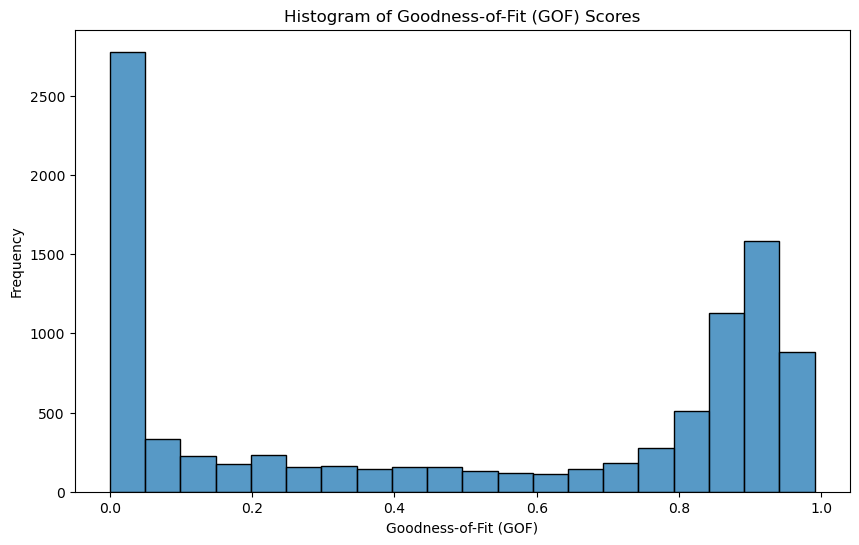

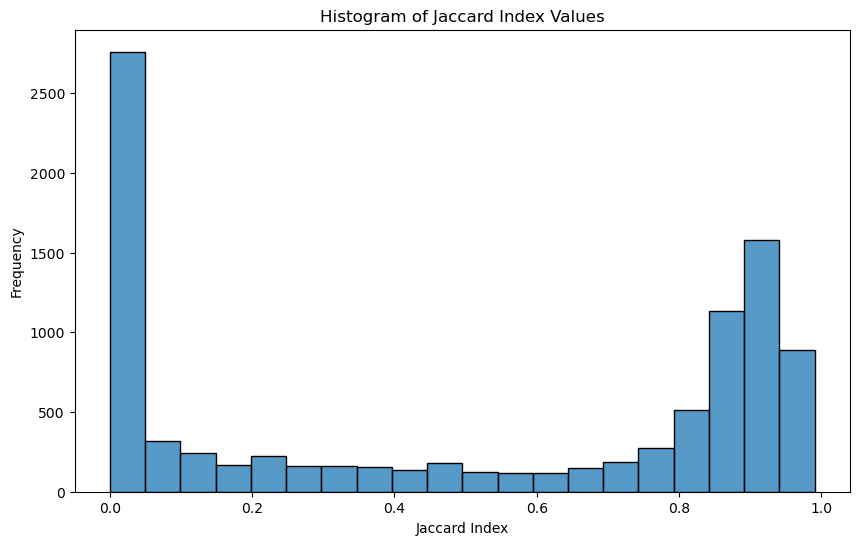

In [70]:
# Print overall GOF and average Jaccard Index
print("Overall GOF:", overall_gof)
print("Average Jaccard Index:", average_jaccard)

# Plot the histogram of GOF scores
plt.figure(figsize=(10, 6))
sns.histplot(intersections_gdf['gof'], bins=20, kde=False)
plt.xlabel('Goodness-of-Fit (GOF)')
plt.ylabel('Frequency')
plt.title('Histogram of Goodness-of-Fit (GOF) Scores')
plt.show()

# Plot the histogram of Jaccard Index values
plt.figure(figsize=(10, 6))
sns.histplot(intersections_gdf['jaccard_index'], bins=20, kde=False)
plt.xlabel('Jaccard Index')
plt.ylabel('Frequency')
plt.title('Histogram of Jaccard Index Values')
plt.show()

Original map2 geometries: 4185
Trimmed map2 geometries: 4160


<Axes: >

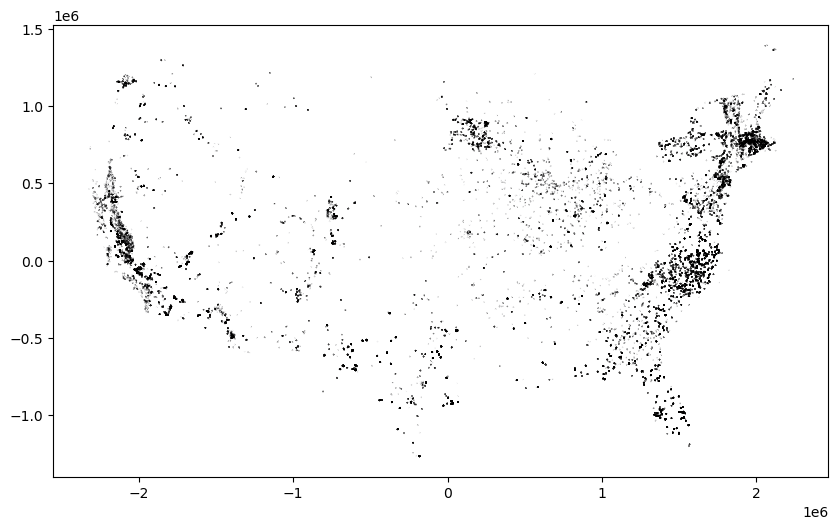

In [58]:
from shapely.geometry import box

def trim_map2_to_map1_bounds(map1, map2, buffer_size=50000):
    """
    Trim map2 to the bounding box of map1, expanded by a buffer.
    
    Parameters:
        map1 (GeoDataFrame): First map with reference bounding box.
        map2 (GeoDataFrame): Second map to be trimmed.
        buffer_size (float): Buffer distance to expand the bounding box, in the units of the CRS.
        
    Returns:
        map2_trimmed (GeoDataFrame): Trimmed version of map2.
    """
    # Get the bounding box of map1
    minx, miny, maxx, maxy = map1.total_bounds
    
    # Expand the bounding box by the buffer size
    expanded_bbox = box(minx - buffer_size, miny - buffer_size,
                        maxx + buffer_size, maxy + buffer_size)
    
    # Create a GeoDataFrame for the expanded bounding box
    bbox_gdf = gpd.GeoDataFrame({'geometry': [expanded_bbox]}, crs=map1.crs)
    
    # Clip map2 to the expanded bounding box
    map2_trimmed = gpd.clip(map2, bbox_gdf)
    
    return map2_trimmed

# Apply the trimming
map2_trimmed = trim_map2_to_map1_bounds(map1, map2)

# Verify the results
print(f"Original map2 geometries: {len(map2)}")
print(f"Trimmed map2 geometries: {len(map2_trimmed)}")

# Visualize the trimmed dataset
ax = map1.plot(color='blue', alpha=0.5, edgecolor='black', figsize=(10, 8))
map2_trimmed.plot(ax=ax, color='red', alpha=0.5, edgecolor='black')

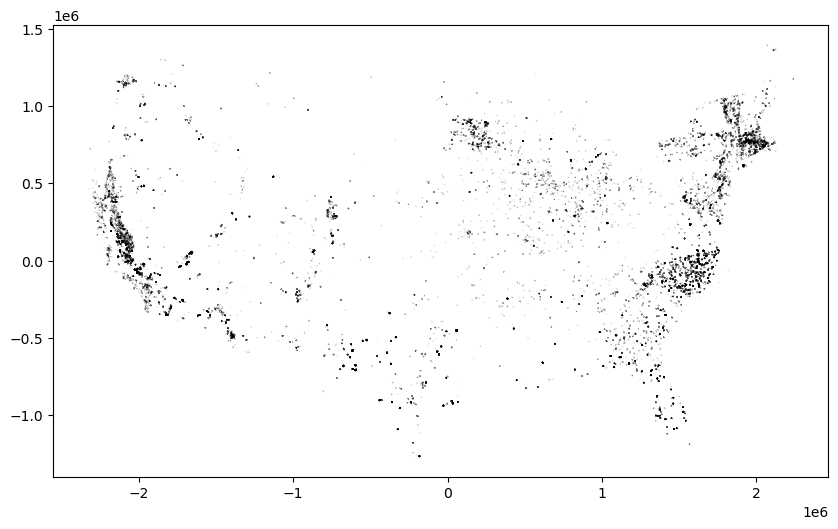

In [59]:
# Plot map 1, labled GMSEUS, include count of rows with a histogram along the top and right showing density
ax = map1.plot(color='blue', alpha=0.5, edgecolor='black', figsize=(10, 8))

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_47824\2004695847.py:36: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax_main.legend()
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_47824\2004695847.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_main.legend()


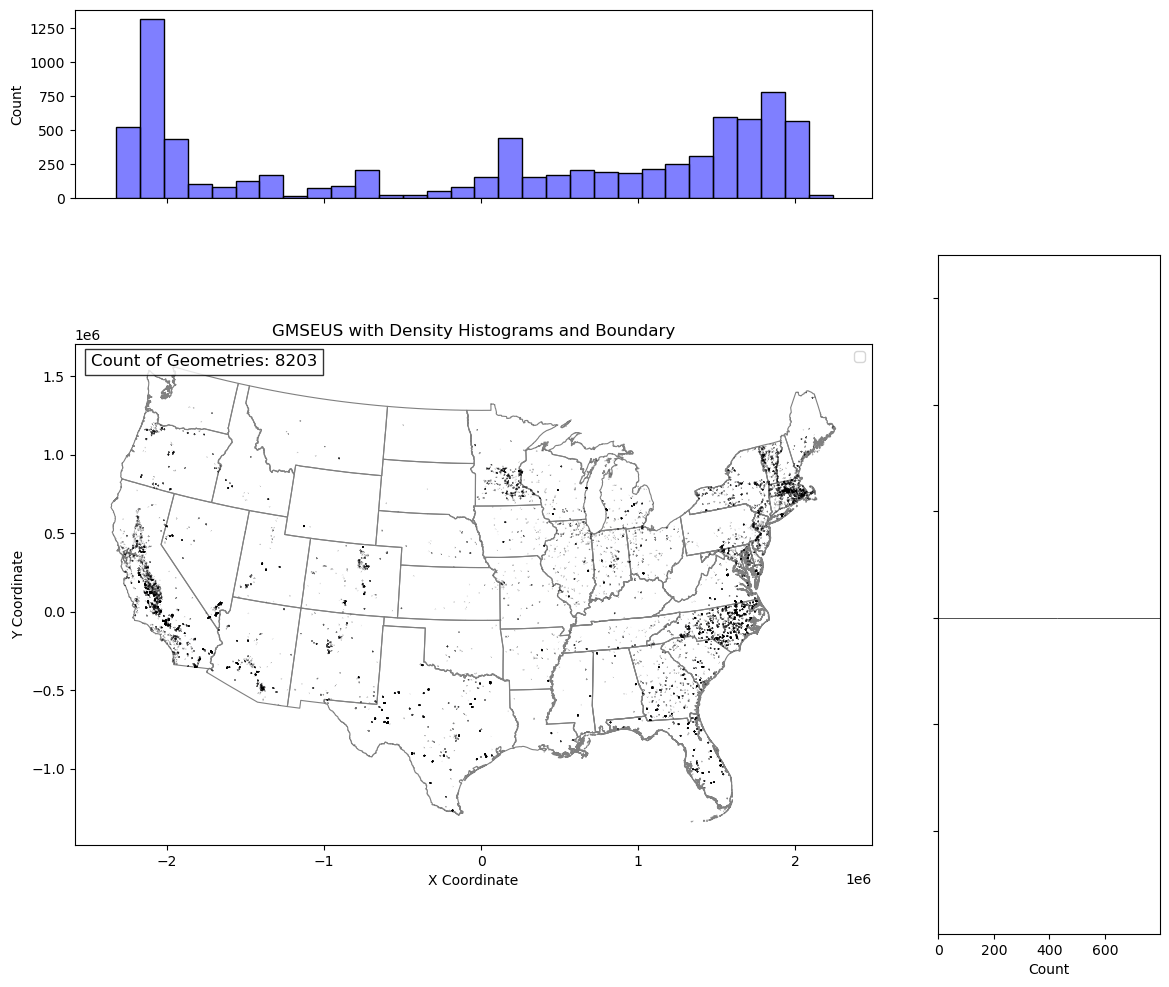

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_47824\2004695847.py:36: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax_main.legend()
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_47824\2004695847.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_main.legend()


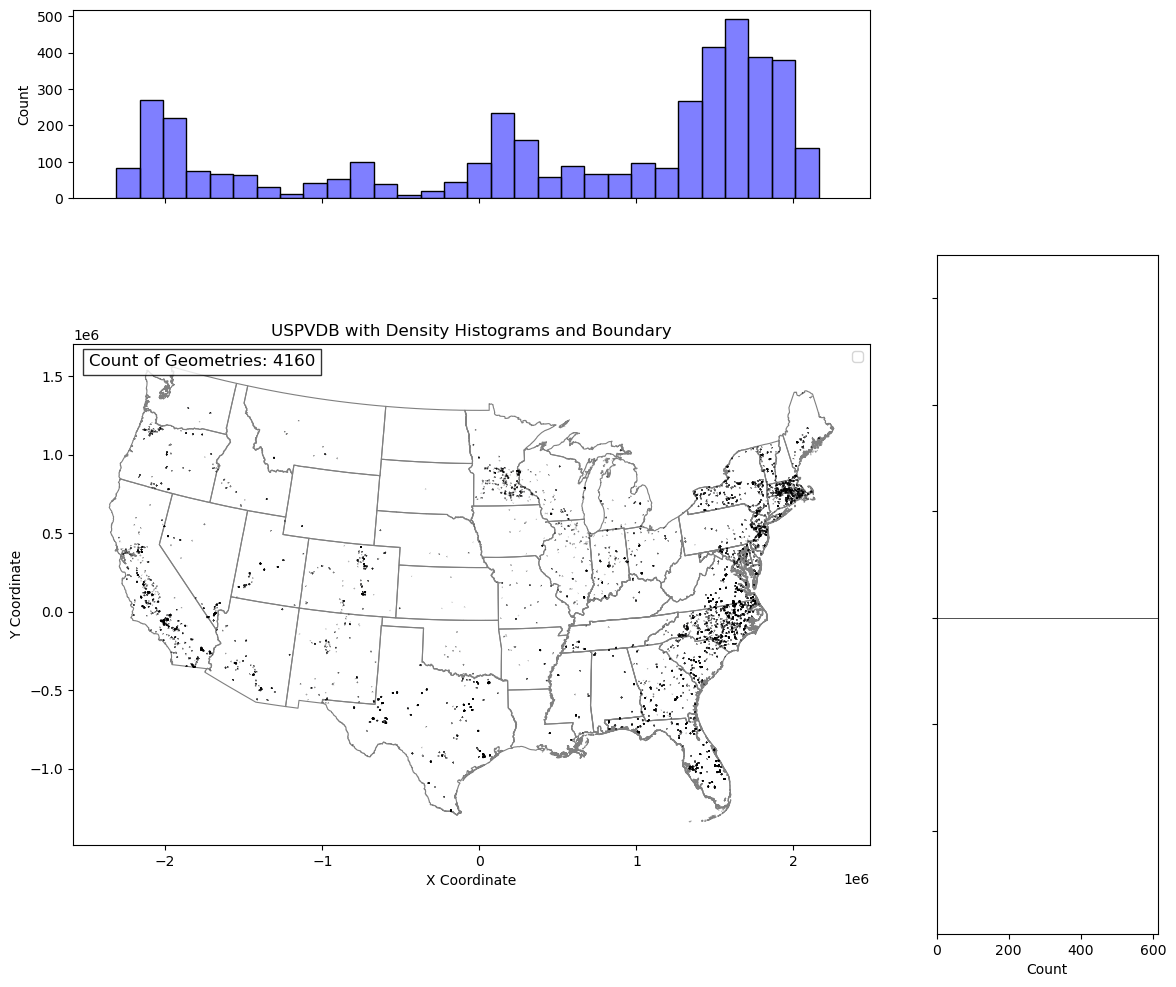

In [77]:
import numpy as np

def plot_map_with_boundary_and_histograms(map_data, map_label, boundary_data):
    """
    Plot a map with histograms for feature density based on x-coordinates (above the map)
    and y-coordinates (to the right of the map). Include a background boundary for reference.
    
    Parameters:
        map_data (GeoDataFrame): GeoDataFrame representing the map to be plotted.
        map_label (str): Label for the map to use in titles and annotations.
        boundary_data (GeoDataFrame): GeoDataFrame representing the background boundary (e.g., lower 48 states).
    """
    # Ensure CRS match between map_data and boundary_data
    if map_data.crs != boundary_data.crs:
        boundary_data = boundary_data.to_crs(map_data.crs)

    # Add x and y coordinates for density calculation (based on centroids)
    map_data['x'] = map_data.geometry.centroid.x
    map_data['y'] = map_data.geometry.centroid.y

    # Clip extreme Y-values for better visualization
    y_min, y_max = np.percentile(map_data['y'], [1, 99])  # Keep the 1st to 99th percentile
    clipped_map_data = map_data[(map_data['y'] >= y_min) & (map_data['y'] <= y_max)]

    # Create a main plot with marginal histograms
    fig = plt.figure(figsize=(14, 12))
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

    # Main plot: map visualization
    ax_main = fig.add_subplot(gs[1:, :-1])
    boundary_data.plot(ax=ax_main, color='none', edgecolor='grey', linewidth=0.8, label="Boundary")
    map_data.plot(ax=ax_main, color='blue', alpha=0.5, edgecolor='black', label="Data")
    ax_main.set_title(f"{map_label} with Density Histograms and Boundary")
    ax_main.set_xlabel("X Coordinate")
    ax_main.set_ylabel("Y Coordinate")
    ax_main.legend()

    # Add count of geometries as a label on the map
    geometry_count = len(map_data)
    ax_main.text(
        0.02, 0.98, f"Count of Geometries: {geometry_count}",
        transform=ax_main.transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.8)
    )

    # Top histogram: X-coordinate density
    ax_top = fig.add_subplot(gs[0, :-1], sharex=ax_main)
    sns.histplot(map_data['x'], kde=False, color="blue", alpha=0.5, bins=30, ax=ax_top)
    ax_top.set_ylabel("Count")
    ax_top.set_xlabel("")
    ax_top.tick_params(axis="x", labelbottom=False)

    # Right histogram: Y-coordinate density
    ax_right = fig.add_subplot(gs[1:, -1], sharey=ax_main)
    sns.histplot(
        clipped_map_data['y'], kde=False, color="blue", alpha=0.5, bins=30,
        ax=ax_right, orientation="horizontal"
    )
    ax_right.set_xlabel("Count")
    ax_right.set_ylabel("")
    ax_right.tick_params(axis="y", labelleft=False)

    # Adjust limits for better visualization
    max_density = np.histogram(clipped_map_data['y'], bins=30)[0].max()
    ax_right.set_xlim(0, max_density + 10)

    plt.show()

# Example usage:
# Boundary data
us_boundary = gpd.read_file("G:\\Data\\GMSEUS\\SupplementaryData\\CONUS_No_Great_Lakes.shp")
us_boundary = us_boundary.to_crs(map1.crs)

# Plot map1
plot_map_with_boundary_and_histograms(map1, "GMSEUS", us_boundary)

# Plot map2_trimmed
plot_map_with_boundary_and_histograms(map2_trimmed, "USPVDB", us_boundary)

In [75]:
def plot_intersections_with_metric(intersections, boundary_data, metric, map_label):
    """
    Plot intersection points with a specified metric (Jaccard or GOF) as a color scale,
    overlaid on a boundary map using x and y coordinates for point locations.
    
    Parameters:
        intersections (GeoDataFrame): GeoDataFrame of intersections with calculated metrics.
        boundary_data (GeoDataFrame): GeoDataFrame representing the boundary (e.g., lower 48 states).
        metric (str): The metric to visualize ("jaccard_index" or "gof").
        map_label (str): Label for the map to use in titles and annotations.
    """
    # Ensure CRS match between intersections and boundary_data
    if intersections.crs != boundary_data.crs:
        boundary_data = boundary_data.to_crs(intersections.crs)

    # Check if the provided metric exists in the intersections GeoDataFrame
    if metric not in intersections.columns:
        raise ValueError(f"Metric '{metric}' not found in the intersections GeoDataFrame.")

    # Extract x and y coordinates for intersections
    intersections['x'] = intersections.geometry.centroid.x
    intersections['y'] = intersections.geometry.centroid.y

    # Create a plot
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Plot the boundary
    boundary_data.plot(ax=ax, color='none', edgecolor='grey', linewidth=0.8, label="Boundary")
    
    # Plot the intersection points with the metric as the color
    scatter = ax.scatter(
        intersections['x'], intersections['y'],
        c=intersections[metric],
        cmap='viridis',
        s=10,
        alpha=0.8,
        label="Intersections"
    )
    
    # Add a colorbar for the metric
    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
    cbar.set_label(f"{metric.capitalize()} Value")

    # Title and labels
    ax.set_title(f"{map_label} Intersections Colored by {metric.capitalize()}")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")

        # Add a count of intersections as a text label
    intersection_count = len(intersections)
    ax.text(
        0.02, 0.98, f"Number of Intersections: {intersection_count}",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.8)
    )
    plt.grid(False)
    plt.legend()

    plt.show()

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_47824\1150846308.py:59: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


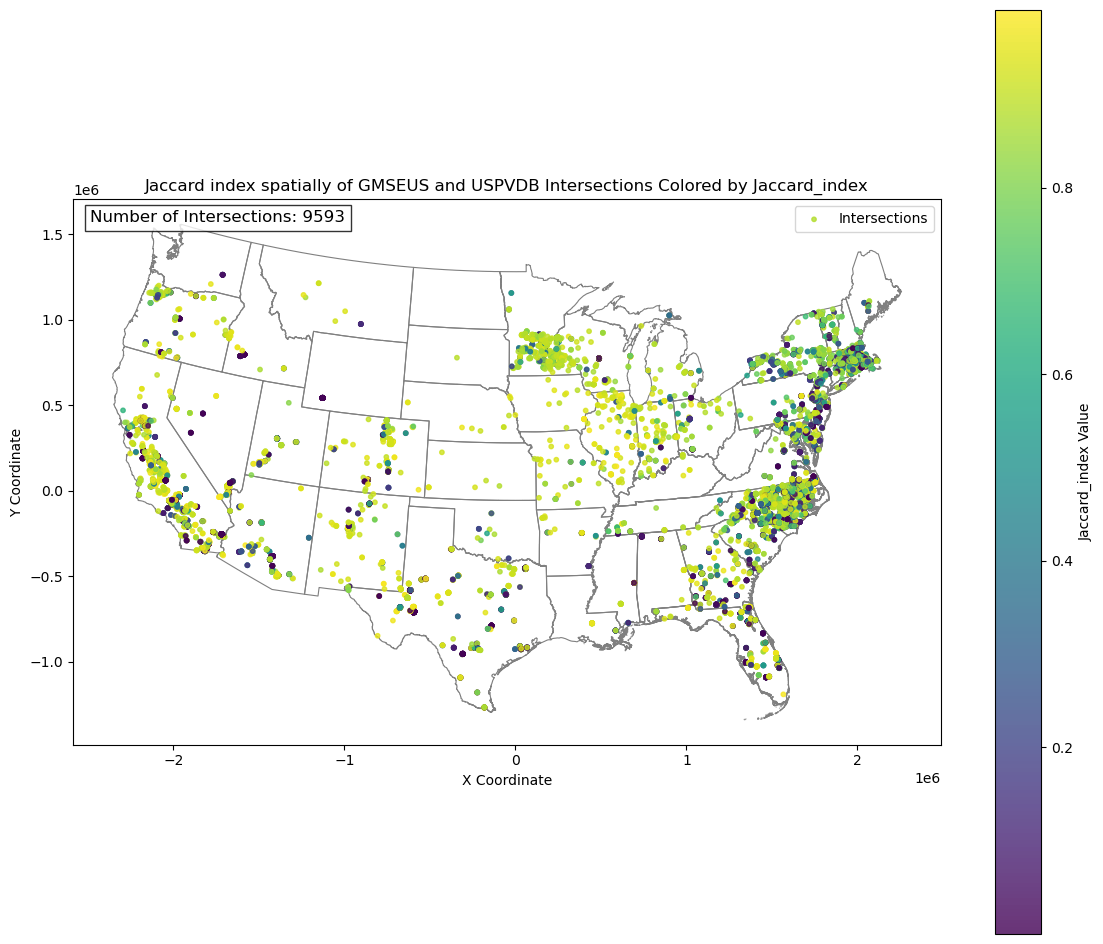

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_47824\1150846308.py:59: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


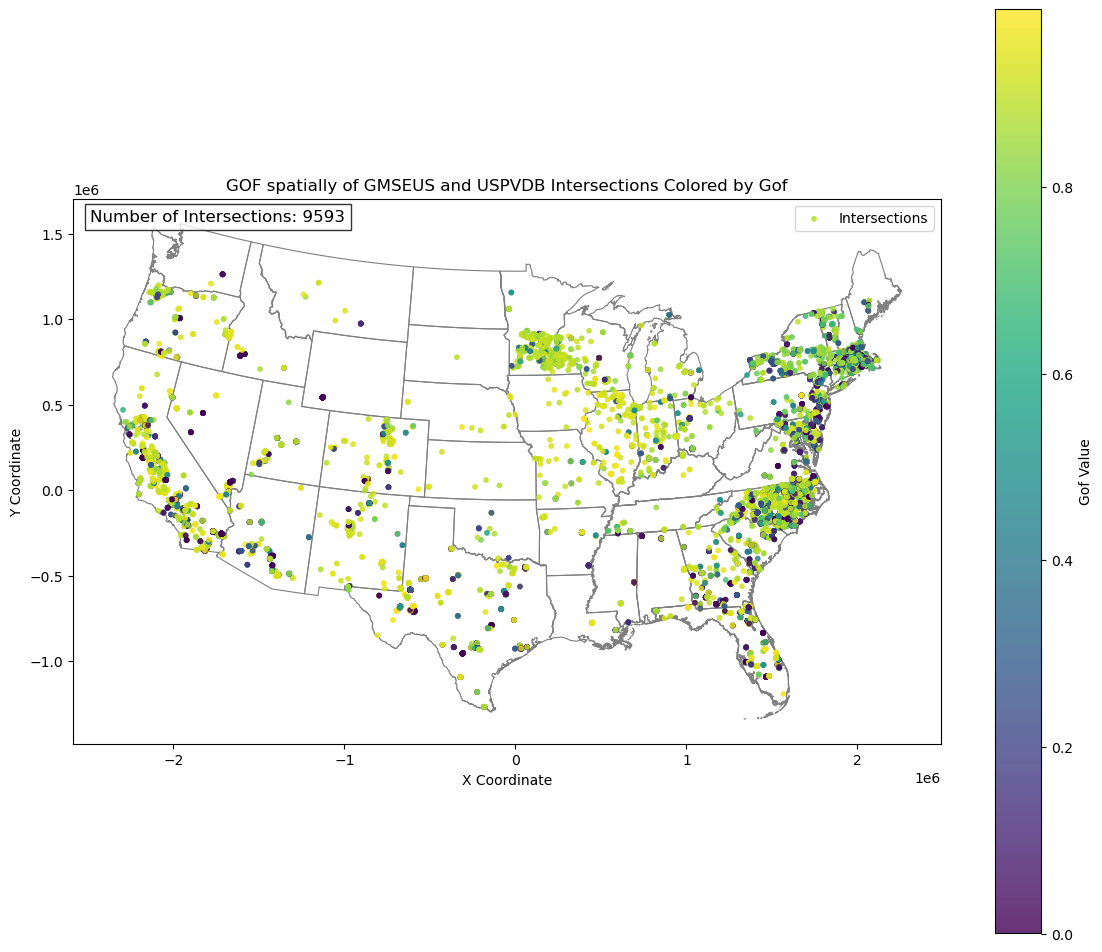

In [76]:
# Plot intersections colored by Jaccard Index
plot_intersections_with_metric(intersections_gdf, us_boundary, "jaccard_index", "Jaccard index spatially of GMSEUS and USPVDB")

# Plot intersections colored by GOF
plot_intersections_with_metric(intersections_gdf, us_boundary, "gof", "GOF spatially of GMSEUS and USPVDB")

g:\Code\Envs\BigPanel\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


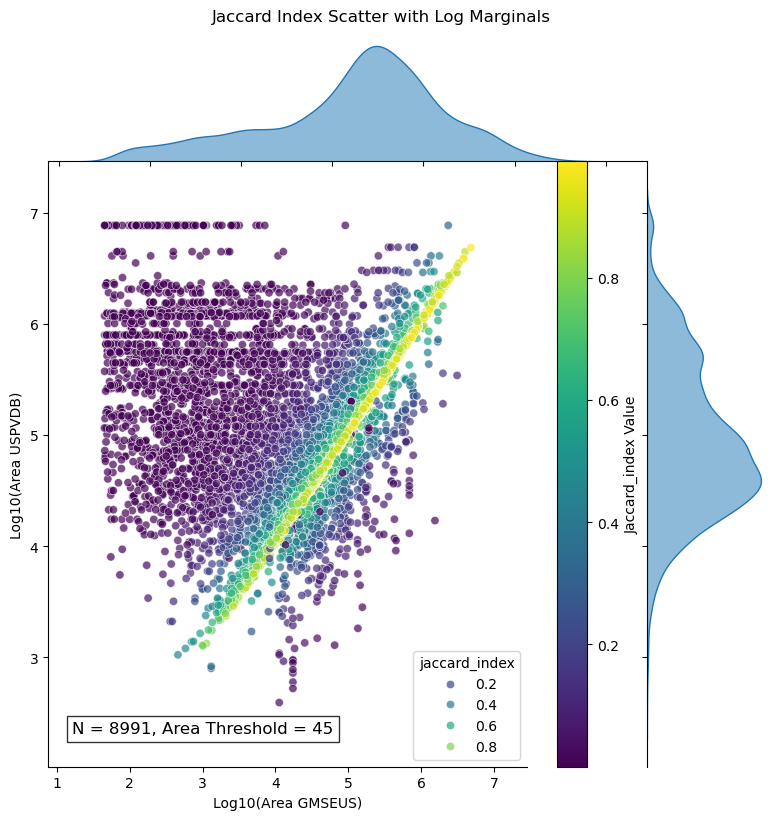

g:\Code\Envs\BigPanel\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


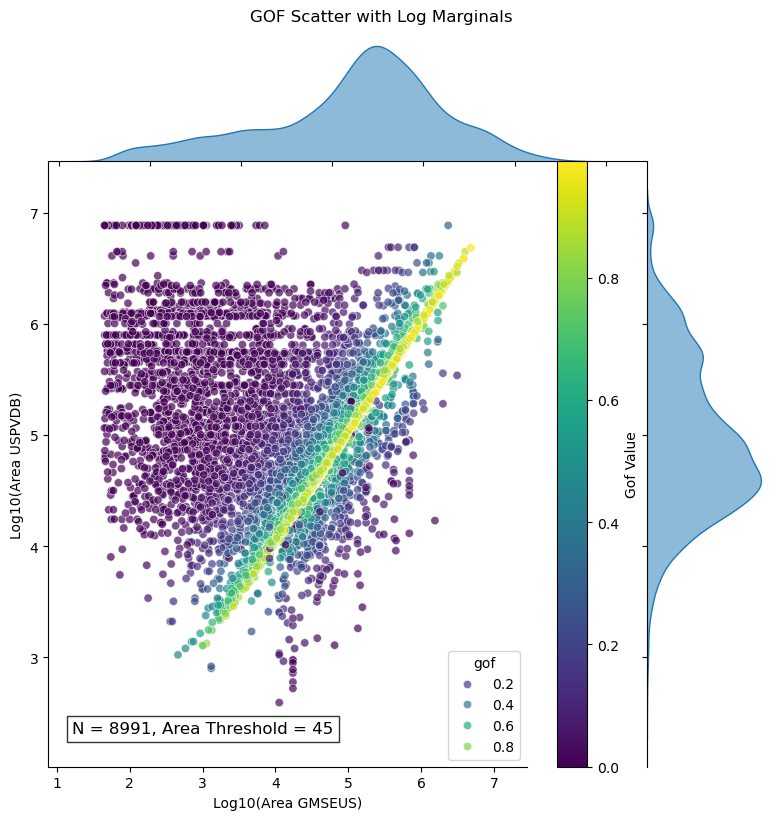

In [86]:
def scatter_with_log_marginals(intersections_gdf, metric, title="Log-Transformed Scatter Plot with Marginal Distributions", area_threshold = 45):
    """
    Scatter plot with log-transformed marginal distributions for areas and color-coded by a given metric.
    
    Parameters:
        intersections_gdf (GeoDataFrame): GeoDataFrame containing intersection data with areas and metrics.
        metric (str): The metric to visualize on the scatter plot ("jaccard_index" or "gof").
        title (str): Title for the plot.
    """
    if metric not in intersections_gdf.columns:
        raise ValueError(f"Metric '{metric}' not found in the GeoDataFrame.")
    # filter out small areas
    intersections_gdf = intersections_gdf[(intersections_gdf['area_a'] > area_threshold) & (intersections_gdf['area_b'] > area_threshold)]

    # Apply log transformation to the area columns
    intersections_gdf['log_area_a'] = np.log10(intersections_gdf['area_a'])
    intersections_gdf['log_area_b'] = np.log10(intersections_gdf['area_b'])
    
    # Set up the grid
    g = sns.JointGrid(data=intersections_gdf, x="log_area_a", y="log_area_b", space=0, height=8)
    
    # Scatter plot in the center
    g.plot_joint(
        sns.scatterplot,
        hue=intersections_gdf[metric],
        palette='viridis',
        alpha=0.7
    )
    
    # KDE plots on the margins
    g.plot_marginals(sns.kdeplot, fill=True, alpha=0.5)
    
    # Customize color bar for the selected metric
    norm = plt.Normalize(intersections_gdf[metric].min(), intersections_gdf[metric].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    cbar = g.fig.colorbar(sm, ax=g.ax_joint, orientation="vertical", label=f"{metric.capitalize()} Value")
    
    # Set labels and title
    g.set_axis_labels("Log10(Area GMSEUS)", "Log10(Area USPVDB)")
    g.fig.suptitle(title, y=1.02)
    
    # Add a count of the number of points in the lower-left of the plot
    g.ax_joint.text(
        0.05, 0.05, f'N = {intersections_gdf.shape[0]}, Area Threshold = {area_threshold}',
        horizontalalignment='left', verticalalignment='bottom',
        transform=g.ax_joint.transAxes,
        fontsize=12, bbox=dict(facecolor='white', alpha=0.8)
    )
    plt.show()

# Example usage:
# Scatter plot with Jaccard Index
scatter_with_log_marginals(intersections_gdf, metric="jaccard_index", title="Jaccard Index Scatter with Log Marginals")

# Scatter plot with GOF
scatter_with_log_marginals(intersections_gdf, metric="gof", title="GOF Scatter with Log Marginals")


In [ ]:
print(map_data['y'].describe())

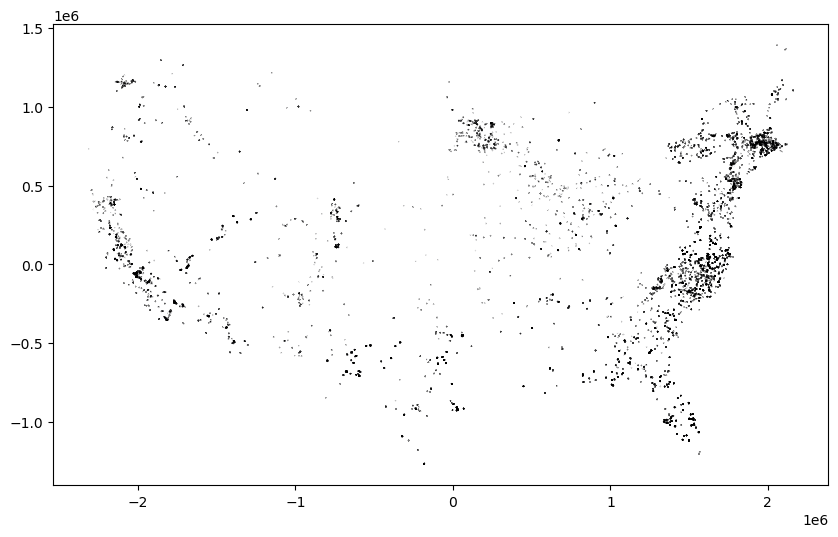

In [60]:
ax = map2_trimmed.plot(color='blue', alpha=0.5, edgecolor='black', figsize=(10, 8))

In [ ]:
import os

def create_combined_boxplot(dataframe, columns_list, title, output_folder, dpi=300, title_fontsize=20):
    """
    Creates a combined boxplot for given variables over years on the same plot, allowing both 'gof' and 'jaccard' metrics
    to be plotted and distinguished in the legend. Incorporates renaming of the columns for appearances.

    :param dataframe: Pandas DataFrame containing the data.
    :param columns_list: List of strings representing the base of column names to be plotted.
    :param title: The title of the plot.
    :param output_folder: The folder where the plot will be saved.
    :param dpi: The resolution of the saved plot in dots per inch.
    :param title_fontsize: The font size of the plot title.
    """
    # Initialize an empty DataFrame for the combined melted data
    combined_df_melted = pd.DataFrame()

    # Dictionary for renaming the variables for the legend
    rename_dict = {
        'aim_irrMapper_gof': 'AIM-HPA & IrrMapper (GOF)',
        'aim_lanid_gof': 'AIM-HPA & LANID (GOF)',
        'irrMapper_lanid_gof': 'IrrMapper & LANID (GOF)',
        'all_gof': 'All 3 (GOF)',
        'aim_irrMapper_jaccard': 'AIM-HPA & IrrMapper (Jaccard)',
        'aim_lanid_jaccard': 'AIM-HPA & LANID (Jaccard)',
        'irrMapper_lanid_jaccard': 'IrrMapper & LANID (Jaccard)'
    }

    for base_name in columns_list:
        # Filter columns matching the base name and extract the year
        relevant_columns = [col for col in dataframe.columns if base_name in col]
        for col in relevant_columns:
            # Extract the year from the column name
            parts = col.split('_')
            year = parts[-1]  # Assumes year is the last part of the column name

            # Prepare a temporary DataFrame for melting
            temp_df = dataframe[['system:index', col]].rename(columns={col: 'value'})
            temp_df['Year'] = year
            # Determine the renamed variable for the legend
            renamed_variable = rename_dict.get(base_name, base_name)  # Fallback to base_name if not found in dict
            temp_df['variable'] = renamed_variable

            # Adding the melted data to the combined DataFrame
            combined_df_melted = pd.concat([combined_df_melted, temp_df], axis=0)

    # Ensure 'Year' is of type int for correct plotting
    combined_df_melted['Year'] = combined_df_melted['Year'].astype(int)

    # Plotting
    plt.figure(figsize=(12, 8), dpi=dpi)
    sns.boxplot(x='Year', y='value', hue='variable', data=combined_df_melted)
    plt.title(title, fontsize=title_fontsize)
    plt.xlabel('Year')
    plt.ylabel('Values')
    plt.xticks(rotation=45)
    plt.legend(title='Products')

    # Check if output folder exists, if not, create it
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Construct file path
    file_name = title.replace(' ', '_').replace('\n', '_').lower() + '.png'
    file_path = os.path.join(output_folder, file_name)

    # Save the figure
    plt.savefig(file_path, dpi=dpi)
    plt.show()  # Show the plot for visual confirmation
    plt.close()  # Close the figure to free up memory

    print(f"Plot saved to {file_path}")
    
# Using the function to create a combined boxplot for both 'aim_irrMapper_gof' and 'aim_lanid_gof'
create_combined_boxplot(data, ['aim_irrMapper_gof', 'aim_lanid_gof', 'irrMapper_lanid_gof', 'all_gof'], 'Boxplots of Goodness of Fit (GOF) \n for 30m Irrigation Products through time', 'Z:\\PHD_Work\\2024\\AGU_Chapman\\Poster_Conference\\')